In [60]:
# Import libraries and actual workflow functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Configure matplotlib for notebook display
plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['figure.dpi'] = 100
import logging
import os
from matplotlib.gridspec import GridSpec

# Import the ACTUAL workflow functions from first_level_workflows.py
from first_level_workflows import extract_cs_conditions, create_contrasts

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Libraries and ACTUAL workflow functions imported successfully")
print("✅ Using real functions from first_level_workflows.py - NOT copies!")

✅ Libraries and ACTUAL workflow functions imported successfully
✅ Using real functions from first_level_workflows.py - NOT copies!


In [61]:
# Jupyter magic commands for matplotlib display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configure matplotlib for optimal notebook display
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

print("✅ Matplotlib configured for notebook display")


✅ Matplotlib configured for notebook display


## Load NARSAD Half-Events Data

Load both phase2 and phase3 half-events data from the behavioral directory.

In [62]:
# Load NARSAD half-events data
behav_dir = "/Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav"
phase2_file = os.path.join(behav_dir, "task-Narsad_phase2_half_events.csv")
phase3_file = os.path.join(behav_dir, "task-Narsad_phase3_half_events.csv")

# Load phase2 data (tab-separated, but needs manual splitting)
df_phase2_raw = pd.read_csv(phase2_file, sep='\t')
df_phase2 = df_phase2_raw.iloc[:, 0].str.split('\t', expand=True)
df_phase2.columns = ['onset', 'duration', 'trial_type']
df_phase2['onset'] = df_phase2['onset'].astype(float)
df_phase2['duration'] = df_phase2['duration'].astype(float)
print(f"Phase2: {len(df_phase2)} trials, {len(df_phase2['trial_type'].unique())} trial types")
print(f"Trial types: {sorted(df_phase2['trial_type'].unique())}")

# Load phase3 data (already properly formatted)
df_phase3 = pd.read_csv(phase3_file, sep='\t')
print(f"\nPhase3: {len(df_phase3)} trials, {len(df_phase3['trial_type'].unique())} trial types")
print(f"Trial types: {sorted(df_phase3['trial_type'].unique())}")

print("\n✅ Data loaded successfully")

Phase2: 63 trials, 12 trial types
Trial types: ['CS-_first_half', 'CS-_second_half', 'CSR_first_half', 'CSR_second_half', 'CSS_first_half', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']

Phase3: 52 trials, 9 trial types
Trial types: ['CS-_first_half', 'CS-_second_half', 'CSR_first_half', 'CSR_second_half', 'CSS_first_half', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'SHOCK']

✅ Data loaded successfully


## Test Actual Workflow Functions

Test the **actual functions** from `first_level_workflows.py` with the half-events data.

In [63]:
# Test Phase2 data with ACTUAL workflow functions
print("=" * 80)
print("TESTING PHASE2 WITH ACTUAL WORKFLOW FUNCTIONS")
print("=" * 80)

# Test extract_cs_conditions function from first_level_workflows.py
df_phase2_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions(df_phase2)
print(f"\n✅ extract_cs_conditions completed for Phase2")
print(f"CS conditions: {cs_conditions}")
print(f"CSS conditions: {css_conditions}")
print(f"CSR conditions: {csr_conditions}")
print(f"Other conditions: {other_conditions}")
print(f"Unique conditions: {sorted(df_phase2_conditions['conditions'].unique())}")

# Test create_contrasts function from first_level_workflows.py
contrasts_phase2, cs_contrasts, css_contrasts, csr_contrasts, other_contrasts = create_contrasts(df_phase2, contrast_type='interesting')
print(f"\n✅ create_contrasts completed for Phase2")
print(f"Generated {len(contrasts_phase2)} contrasts")
print(f"First 5 contrasts: {[c[0] for c in contrasts_phase2[:5]]}")

INFO:first_level_workflows:Using DataFrame input with 63 trials
INFO:first_level_workflows:DataFrame columns: ['onset', 'duration', 'trial_type', 'conditions']
INFO:first_level_workflows:CS-_first_half conditions: first trial at index 0, 3 others
INFO:first_level_workflows:CSS_first_half conditions: first trial at index 16, 3 others
INFO:first_level_workflows:CSR_first_half conditions: first trial at index 8, 3 others
INFO:first_level_workflows:Unique conditions for contrast generation: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
INFO:first_level_workflows:Processed conditions: CS-={'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others']}, CSS={'first': 'CSS_first_half_first', 'other':

TESTING PHASE2 WITH ACTUAL WORKFLOW FUNCTIONS

✅ extract_cs_conditions completed for Phase2
CS conditions: {'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others']}
CSS conditions: {'first': 'CSS_first_half_first', 'other': ['CSS_first_half_others']}
CSR conditions: {'first': 'CSR_first_half_first', 'other': ['CSR_first_half_others']}
Other conditions: ['FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']
Unique conditions: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'US_CSR_first_half', 'US_CSR_second_half', 'US_CSS_first_half', 'US_CSS_second_half']

✅ create_contrasts completed for Phase2
Generated 9 contrasts
First 5 contrasts: ['CS-_first_half_others > FIXATION_first_half', 'CSS_first_h

In [64]:
# Test Phase3 data with ACTUAL workflow functions
print("=" * 80)
print("TESTING PHASE3 WITH ACTUAL WORKFLOW FUNCTIONS")
print("=" * 80)

# Test extract_cs_conditions function from first_level_workflows.py
df_phase3_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions(df_phase3)
print(f"\n✅ extract_cs_conditions completed for Phase3")
print(f"CS conditions: {cs_conditions}")
print(f"CSS conditions: {css_conditions}")
print(f"CSR conditions: {csr_conditions}")
print(f"Other conditions: {other_conditions}")
print(f"Unique conditions: {sorted(df_phase3_conditions['conditions'].unique())}")

# Test create_contrasts function from first_level_workflows.py
contrasts_phase3, cs_contrasts, css_contrasts, csr_contrasts, other_contrasts = create_contrasts(df_phase3, contrast_type='interesting')
print(f"\n✅ create_contrasts completed for Phase3")
print(f"Generated {len(contrasts_phase3)} contrasts")
print(f"First 5 contrasts: {[c[0] for c in contrasts_phase3[:5]]}")

INFO:first_level_workflows:Using DataFrame input with 52 trials
INFO:first_level_workflows:DataFrame columns: ['onset', 'duration', 'trial_type', 'conditions']
INFO:first_level_workflows:CS-_first_half conditions: first trial at index 0, 3 others
INFO:first_level_workflows:CSS_first_half conditions: first trial at index 16, 3 others
INFO:first_level_workflows:CSR_first_half conditions: first trial at index 8, 3 others
INFO:first_level_workflows:Unique conditions for contrast generation: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'SHOCK']
INFO:first_level_workflows:Processed conditions: CS-={'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others']}, CSS={'first': 'CSS_first_half_first', 'other': ['CSS_first_half_others']}, CSR={'first': 'CSR_first_half_first', 'other': [

TESTING PHASE3 WITH ACTUAL WORKFLOW FUNCTIONS

✅ extract_cs_conditions completed for Phase3
CS conditions: {'first': 'CS-_first_half_first', 'other': ['CS-_first_half_others']}
CSS conditions: {'first': 'CSS_first_half_first', 'other': ['CSS_first_half_others']}
CSR conditions: {'first': 'CSR_first_half_first', 'other': ['CSR_first_half_others']}
Other conditions: ['FIXATION_first_half', 'FIXATION_second_half', 'SHOCK']
Unique conditions: ['CS-_first_half_first', 'CS-_first_half_others', 'CS-_second_half', 'CSR_first_half_first', 'CSR_first_half_others', 'CSR_second_half', 'CSS_first_half_first', 'CSS_first_half_others', 'CSS_second_half', 'FIXATION_first_half', 'FIXATION_second_half', 'SHOCK']

✅ create_contrasts completed for Phase3
Generated 9 contrasts
First 5 contrasts: ['CS-_first_half_others > FIXATION_first_half', 'CSS_first_half_others > FIXATION_first_half', 'CSR_first_half_others > FIXATION_first_half', 'CSS_first_half_others > CSR_first_half_others', 'CSR_first_half_others 

## Phase2 Design Matrix Visualization

Visualize the design matrix for Phase2 data with chronological trial ordering.

PHASE2 DESIGN MATRIX VISUALIZATION
Trials sorted by onset time (chronological order)
First 10 trials: ['FIXATION_first_half', 'CS-_first_half', 'FIXATION_first_half', 'CSS_first_half', 'US_CSS_first_half', 'FIXATION_first_half', 'CSR_first_half', 'US_CSR_first_half', 'FIXATION_first_half', 'CSR_first_half']
Trial timing range: 0s to 455s
Total duration: 455s


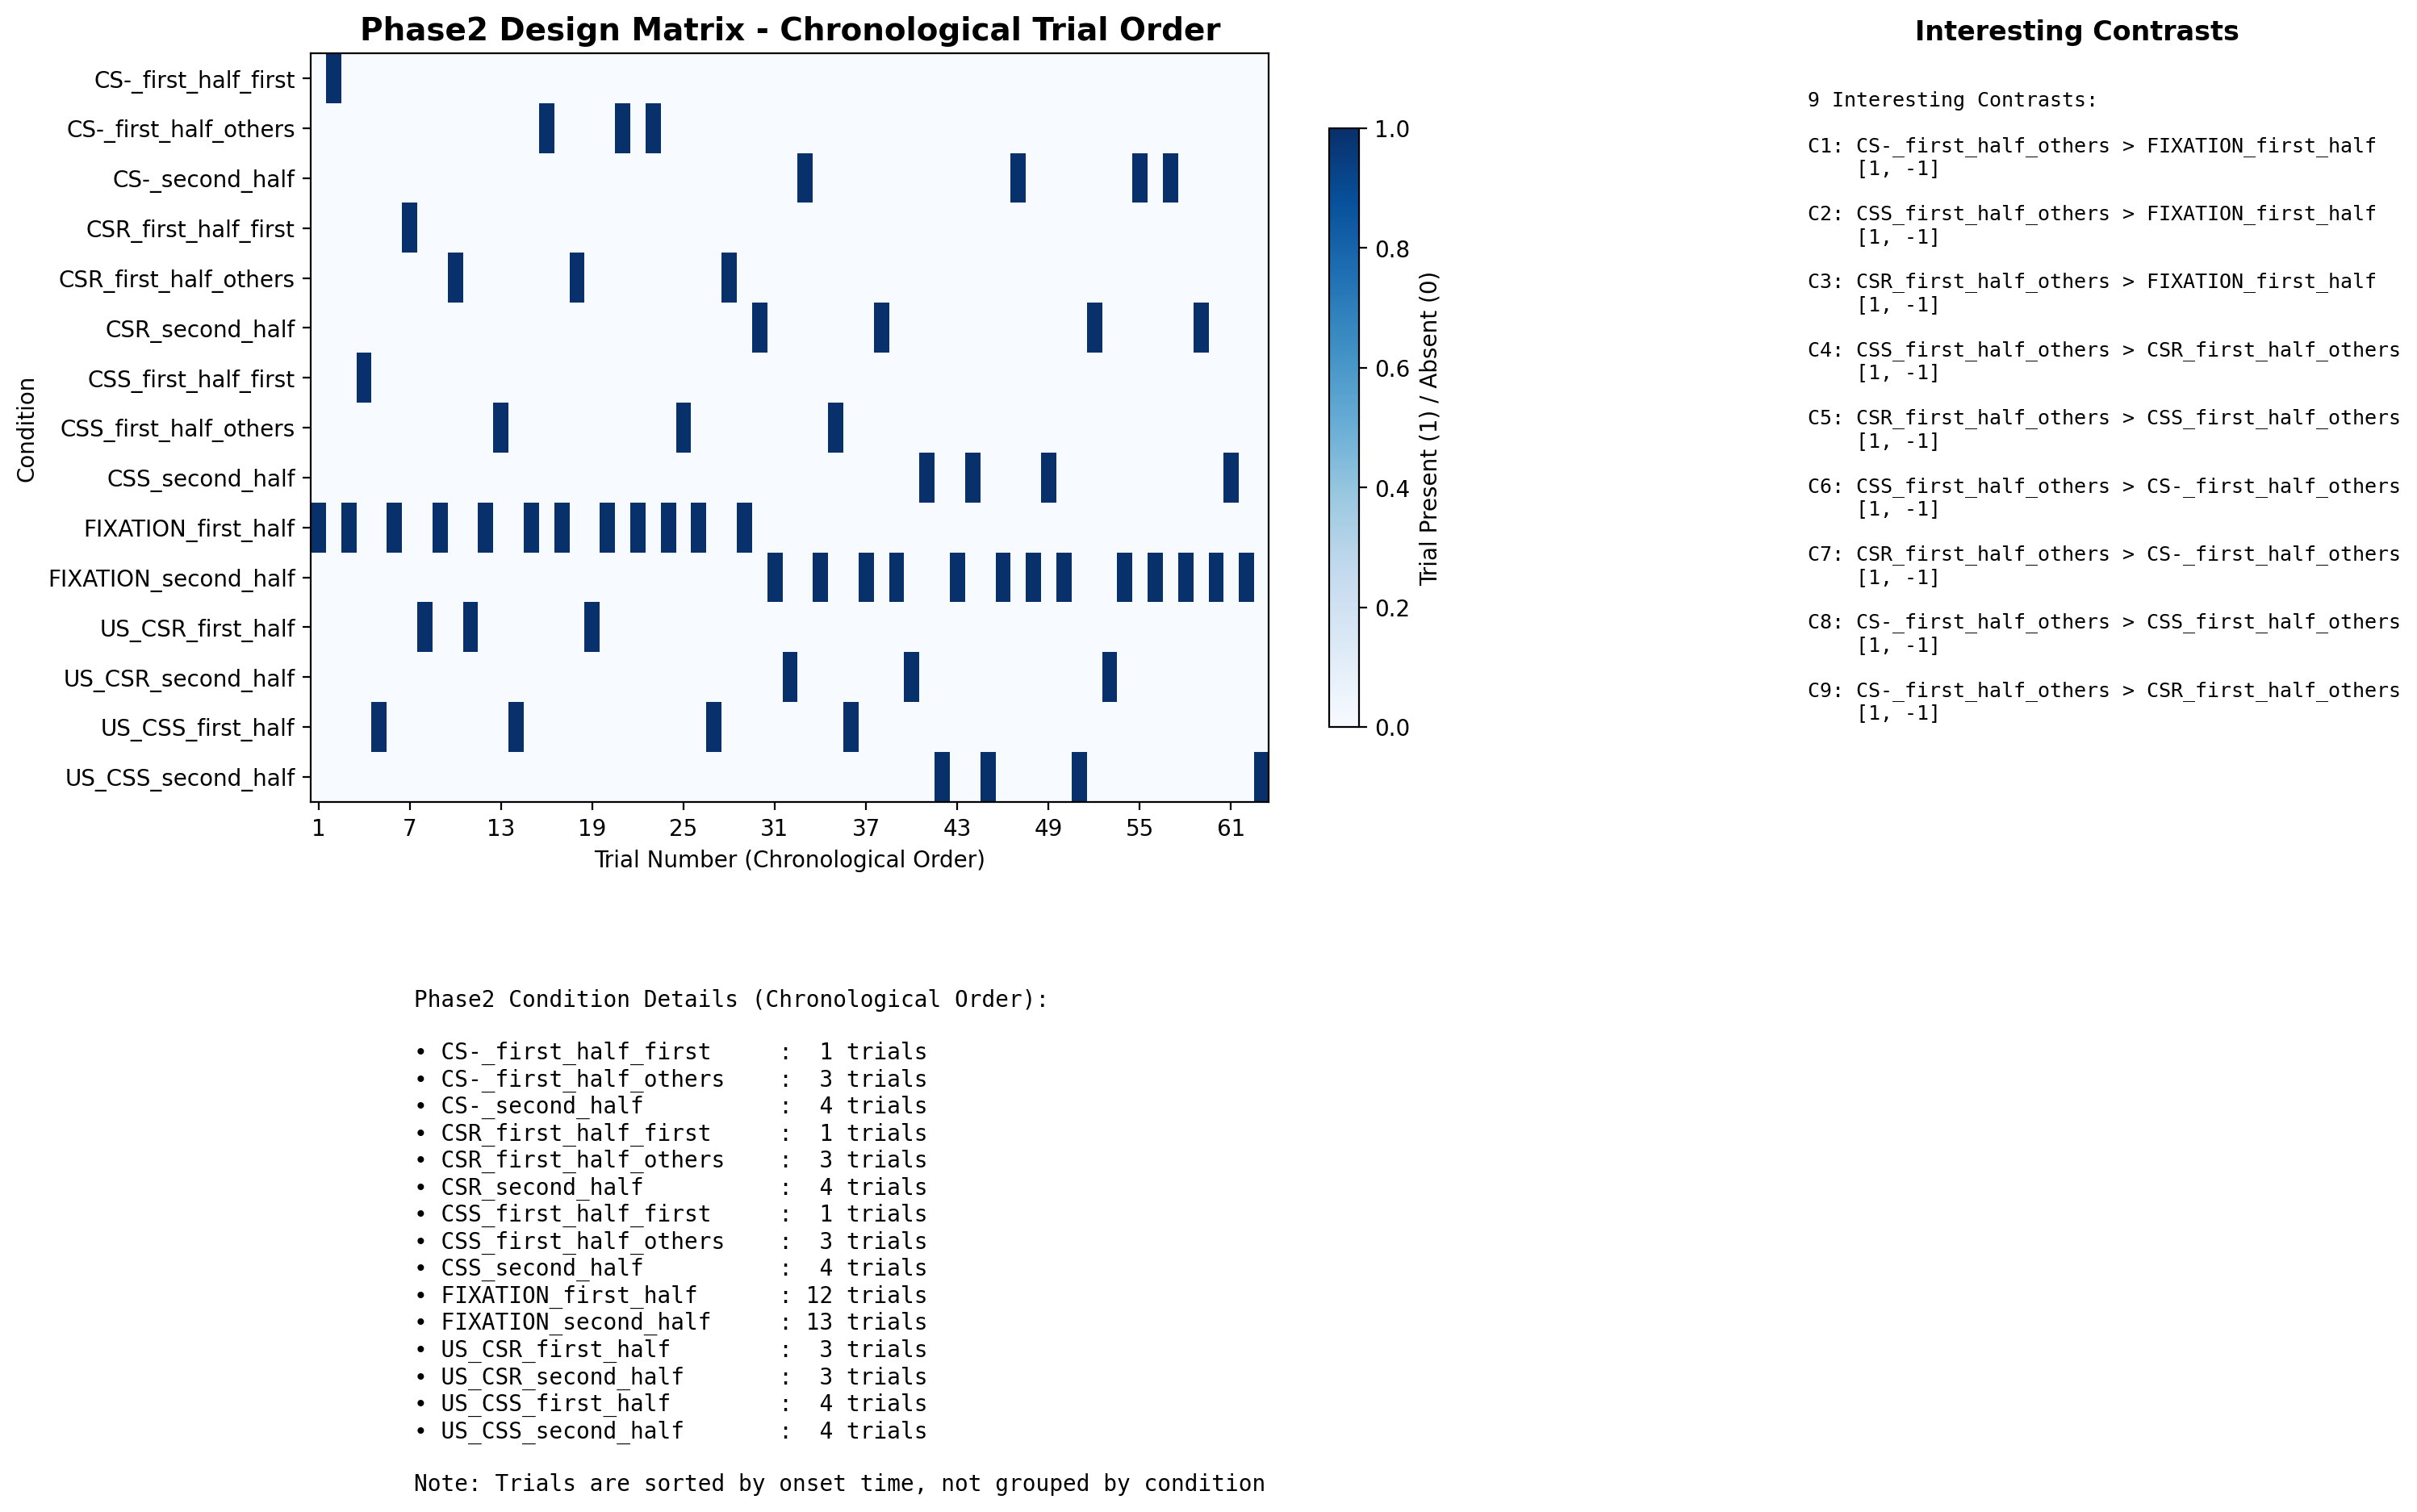


✅ PHASE2 VISUALIZATION COMPLETE!
✅ Design matrix shows 15 conditions
✅ Generated 9 interesting contrasts
✅ Trial numbering: 1 to 63 in chronological order (sorted by onset time)


In [67]:
# Phase2 Design Matrix Visualization
print("=" * 60)
print("PHASE2 DESIGN MATRIX VISUALIZATION")
print("=" * 60)

# Sort trials by onset time to show chronological order
df_phase2_sorted = df_phase2_conditions.sort_values('onset').reset_index(drop=True)
print(f"Trials sorted by onset time (chronological order)")
print(f"First 10 trials: {df_phase2_sorted['trial_type'].head(10).tolist()}")
print(f"Trial timing range: {df_phase2_sorted['onset'].min():.0f}s to {df_phase2_sorted['onset'].max():.0f}s")
print(f"Total duration: {df_phase2_sorted['onset'].max() - df_phase2_sorted['onset'].min():.0f}s")

# Create visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Get unique conditions and create design matrix
unique_conditions = sorted(df_phase2_sorted['conditions'].unique())
n_conditions = len(unique_conditions)
n_trials = len(df_phase2_sorted)

# Create design matrix representation (chronological order)
design_matrix = np.zeros((n_trials, n_conditions))
for i, condition in enumerate(unique_conditions):
    trial_indices = df_phase2_sorted[df_phase2_sorted['conditions'] == condition].index
    design_matrix[trial_indices, i] = 1

# Main design matrix plot
ax_main = fig.add_subplot(gs[0, 0])
im = ax_main.imshow(design_matrix.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax_main.set_xlabel('Trial Number (Chronological Order)')
ax_main.set_ylabel('Condition')
ax_main.set_title('Phase2 Design Matrix - Chronological Trial Order', fontsize=14, fontweight='bold')

# Set x-axis labels to show actual trial numbers (1-based) in chronological order
trial_numbers = range(1, n_trials + 1)
ax_main.set_xticks(range(0, n_trials, max(1, n_trials // 10)))  # Show every nth trial
ax_main.set_xticklabels([str(i) for i in trial_numbers[::max(1, n_trials // 10)]])

# Set y-axis labels
ax_main.set_yticks(range(n_conditions))
ax_main.set_yticklabels(unique_conditions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_main, shrink=0.8)
cbar.set_label('Trial Present (1) / Absent (0)', fontsize=10)

# Right panel - Contrast information
ax_contrasts = fig.add_subplot(gs[0, 1])
ax_contrasts.axis('off')

# Show the interesting contrasts
contrast_text = f"{len(contrasts_phase2)} Interesting Contrasts:\n\n"
for i, contrast in enumerate(contrasts_phase2, 1):
    contrast_text += f"C{i}: {contrast[0]}\n"
    if len(contrast) > 3:
        contrast_text += f"    {contrast[3]}\n\n"
    else:
        contrast_text += "\n"

ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                 fontsize=9, verticalalignment='top', fontfamily='monospace')
ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')

# Bottom panel - Condition details
ax_details = fig.add_subplot(gs[1, :])
ax_details.axis('off')

# Create condition details table
condition_counts = df_phase2_sorted['conditions'].value_counts()
details_text = "Phase2 Condition Details (Chronological Order):\n\n"
for condition in unique_conditions:
    count = condition_counts[condition]
    details_text += f"• {condition:<25}: {count:2d} trials\n"
details_text += f"\nNote: Trials are sorted by onset time, not grouped by condition"

ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

# Adjust layout to prevent tight_layout warning
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()
plt.close()  # Close figure to free memory


print(f"\n✅ PHASE2 VISUALIZATION COMPLETE!")
print(f"✅ Design matrix shows {n_conditions} conditions")
print(f"✅ Generated {len(contrasts_phase2)} interesting contrasts")
print(f"✅ Trial numbering: 1 to {n_trials} in chronological order (sorted by onset time)")

## Phase3 Design Matrix Visualization

Visualize the design matrix for Phase3 data with chronological trial ordering.

PHASE3 DESIGN MATRIX VISUALIZATION
Trials sorted by onset time (chronological order)
First 10 trials: ['SHOCK', 'SHOCK', 'SHOCK', 'FIXATION_first_half', 'CS-_first_half', 'FIXATION_first_half', 'CSS_first_half', 'FIXATION_first_half', 'CSR_first_half', 'FIXATION_first_half']
Trial timing range: 0s to 484s
Total duration: 484s


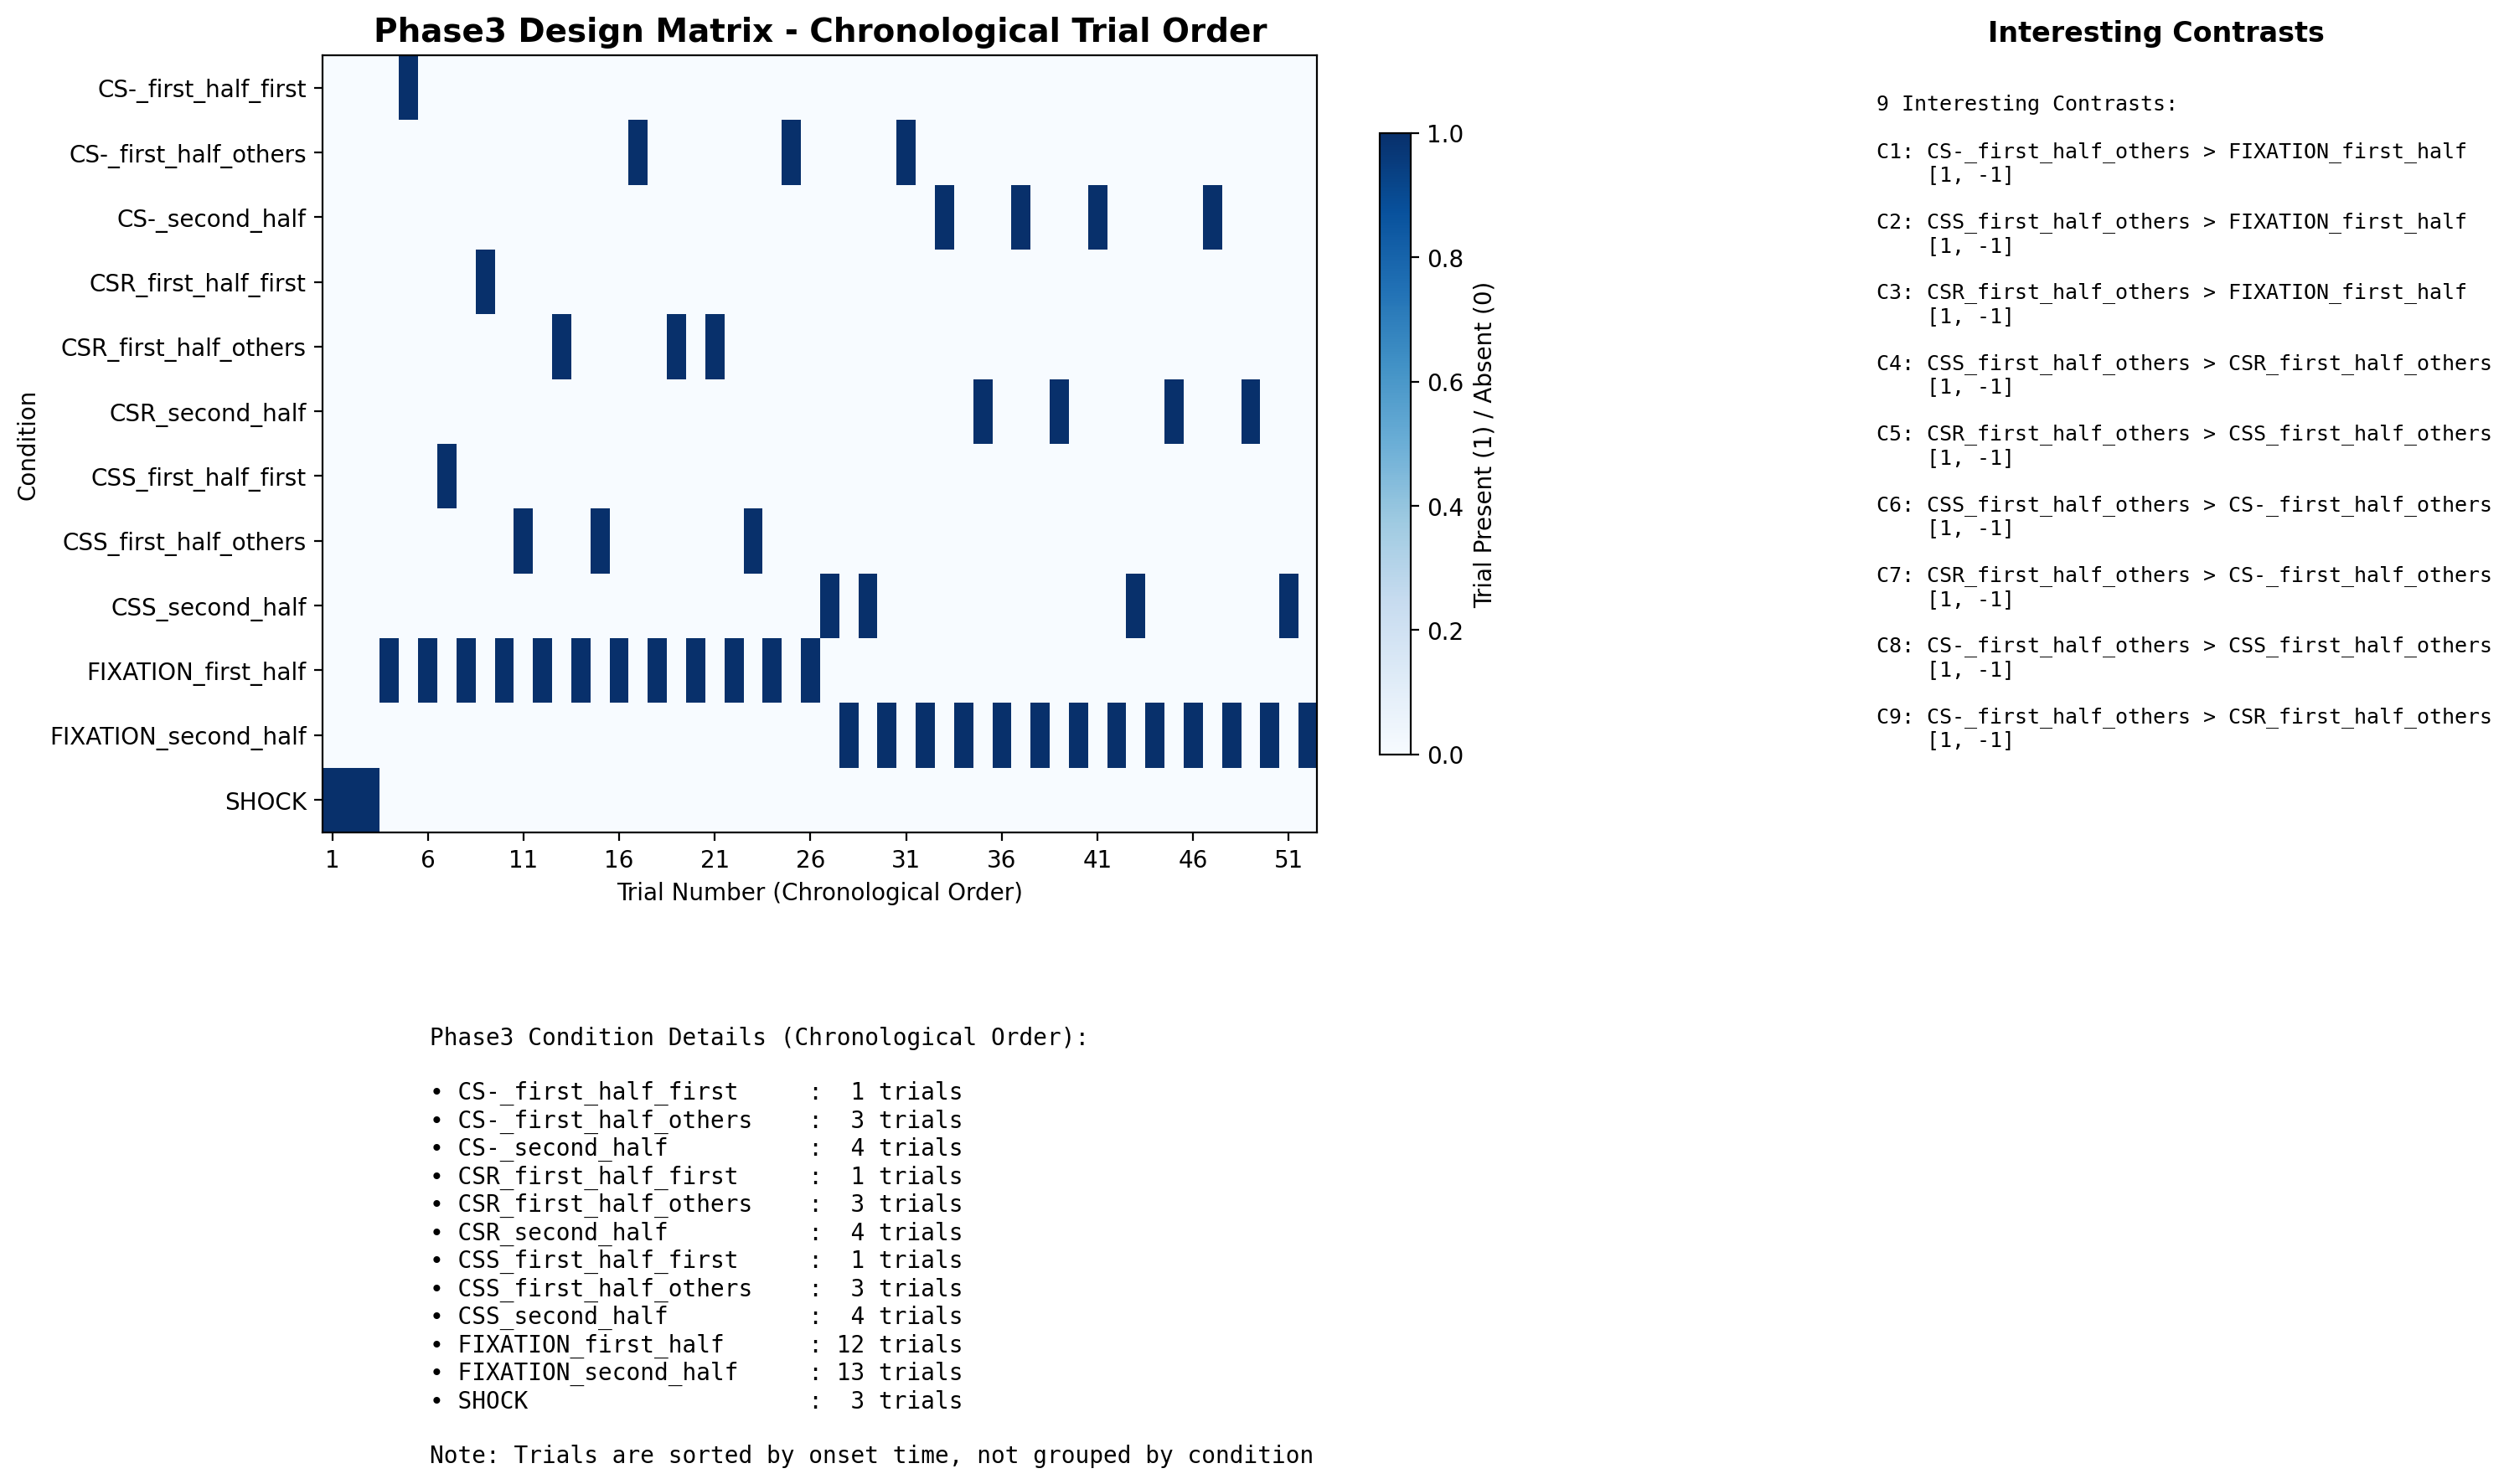


✅ PHASE3 VISUALIZATION COMPLETE!
✅ Design matrix shows 12 conditions
✅ Generated 9 interesting contrasts
✅ Trial numbering: 1 to 52 in chronological order (sorted by onset time)


In [66]:
# Phase3 Design Matrix Visualization
print("=" * 60)
print("PHASE3 DESIGN MATRIX VISUALIZATION")
print("=" * 60)

# Sort trials by onset time to show chronological order
df_phase3_sorted = df_phase3_conditions.sort_values('onset').reset_index(drop=True)
print(f"Trials sorted by onset time (chronological order)")
print(f"First 10 trials: {df_phase3_sorted['trial_type'].head(10).tolist()}")
print(f"Trial timing range: {df_phase3_sorted['onset'].min():.0f}s to {df_phase3_sorted['onset'].max():.0f}s")
print(f"Total duration: {df_phase3_sorted['onset'].max() - df_phase3_sorted['onset'].min():.0f}s")

# Create visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Get unique conditions and create design matrix
unique_conditions = sorted(df_phase3_sorted['conditions'].unique())
n_conditions = len(unique_conditions)
n_trials = len(df_phase3_sorted)

# Create design matrix representation (chronological order)
design_matrix = np.zeros((n_trials, n_conditions))
for i, condition in enumerate(unique_conditions):
    trial_indices = df_phase3_sorted[df_phase3_sorted['conditions'] == condition].index
    design_matrix[trial_indices, i] = 1

# Main design matrix plot
ax_main = fig.add_subplot(gs[0, 0])
im = ax_main.imshow(design_matrix.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax_main.set_xlabel('Trial Number (Chronological Order)')
ax_main.set_ylabel('Condition')
ax_main.set_title('Phase3 Design Matrix - Chronological Trial Order', fontsize=14, fontweight='bold')

# Set x-axis labels to show actual trial numbers (1-based) in chronological order
trial_numbers = range(1, n_trials + 1)
ax_main.set_xticks(range(0, n_trials, max(1, n_trials // 10)))  # Show every nth trial
ax_main.set_xticklabels([str(i) for i in trial_numbers[::max(1, n_trials // 10)]])

# Set y-axis labels
ax_main.set_yticks(range(n_conditions))
ax_main.set_yticklabels(unique_conditions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_main, shrink=0.8)
cbar.set_label('Trial Present (1) / Absent (0)', fontsize=10)

# Right panel - Contrast information
ax_contrasts = fig.add_subplot(gs[0, 1])
ax_contrasts.axis('off')

# Show the interesting contrasts
contrast_text = f"{len(contrasts_phase3)} Interesting Contrasts:\n\n"
for i, contrast in enumerate(contrasts_phase3, 1):
    contrast_text += f"C{i}: {contrast[0]}\n"
    if len(contrast) > 3:
        contrast_text += f"    {contrast[3]}\n\n"
    else:
        contrast_text += "\n"

ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                 fontsize=9, verticalalignment='top', fontfamily='monospace')
ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')

# Bottom panel - Condition details
ax_details = fig.add_subplot(gs[1, :])
ax_details.axis('off')

# Create condition details table
condition_counts = df_phase3_sorted['conditions'].value_counts()
details_text = "Phase3 Condition Details (Chronological Order):\n\n"
for condition in unique_conditions:
    count = condition_counts[condition]
    details_text += f"• {condition:<25}: {count:2d} trials\n"
details_text += f"\nNote: Trials are sorted by onset time, not grouped by condition"

ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

# Adjust layout to prevent tight_layout warning
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()
plt.close()  # Close figure to free memory

print(f"\n✅ PHASE3 VISUALIZATION COMPLETE!")
print(f"✅ Design matrix shows {n_conditions} conditions")
print(f"✅ Generated {len(contrasts_phase3)} interesting contrasts")
print(f"✅ Trial numbering: 1 to {n_trials} in chronological order (sorted by onset time)")